# CSV/Excel 데이터 분석 Agent

Pandas DataFrame 을 활용하여 분석을 수행하는 Agent 를 생성할 수 있습니다.

CSV/Excel 데이터로부터 Pandas DataFrame 객체를 생성할 수 있으며, 이를 활용하여 Agent 가 Pandas query 를 생성하여 분석을 수행할 수 있습니다.

- 출처 : https://wikidocs.net/262597

In [1]:
# !pip install dotenv
# !pip install langchain==0.3.27
# !pip install langchain-community==0.3.27
# !pip install langchain-core==0.3.72
# !pip install langchain-experimental==0.3.4
# !pip install langchain-openai==0.3.28
# !pip install langchain-teddynote

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

False

In [2]:
import pandas as pd
# 1) CSV를 읽어 Pandas DataFrame 생성
#    - 여기서는 Colab 샘플 데이터를 사용합니다.
#    - 실제로는 사용자 CSV 경로로 교체하세요.

df = pd.read_csv("./california_housing_train.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Calculate the correlation matrix\ncorrelation_matrix = df.corr()\n\n# Set up the matplotlib figure\nplt.figure(figsize=(10, 8))\n\n# Draw the heatmap with the mask and correct aspect ratio\nsns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='muted', square=True, cbar_kws={'shrink': .8})\n\nplt.title('Correlation Heatmap')\nplt.show()"}`


KeyError: "'muted' is not a known colormap name"
Invoking: `python_repl_ast` with `{'query': "import seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Calculate the correlation matrix\ncorrelation_matrix = df.corr()\n\n# Set up the matplotlib figure\nplt.figure(figsize=(10, 8))\n\n# Draw the heatmap with the mask and correct aspect ratio\nsns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='Blues', square=True, cbar_kws={'shrink': .8})\n\nplt.title('Correlation Heatmap')\nplt.show()"}`




<Figure size 1000x800 with 0 Axes>

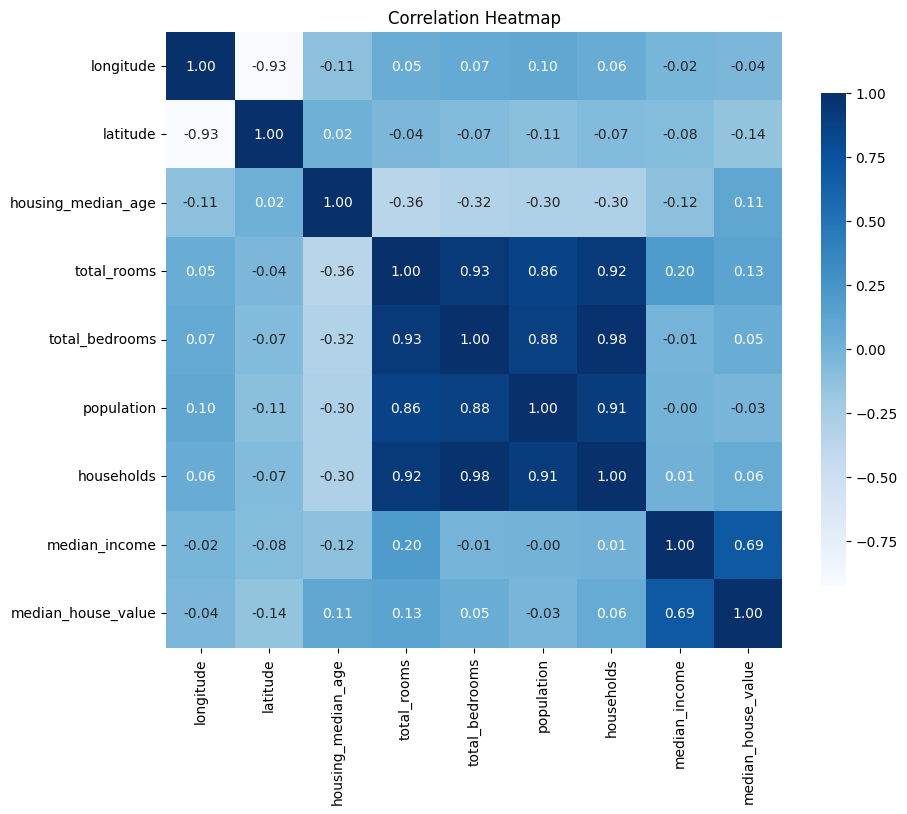

The correlation heatmap has been generated successfully. It visualizes the relationships between the different numerical features in the dataset. If you have any further requests or need additional analysis, feel free to ask!The correlation heatmap has been generated successfully. It visualizes the relationships between the different numerical features in the dataset. If you have any further requests or need additional analysis, feel free to ask!

> Finished chain.


{'input': 'corr()를 구해서 히트맵 시각화',
 'output': 'The correlation heatmap has been generated successfully. It visualizes the relationships between the different numerical features in the dataset. If you have any further requests or need additional analysis, feel free to ask!'}

In [5]:
# 2) LLM 클라이언트 준비
#    - model: OpenAI의 gpt-4o (-> 사내 API로 변경 필요)
#    - streaming=True: 응답 토큰을 실시간 스트리밍
#    - callbacks=[StreamingStdOutCallbackHandler()]:
#        표준 출력(콘솔/노트북 셀)에 토큰이 흘러나오게 함

from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler


llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    streaming=True,  # 토큰 스트리밍
    callbacks=[StreamingStdOutCallbackHandler()],  # 표준 출력으로 토큰 스트림
)

# 3) Pandas DataFrame Agent 생성
#    - create_pandas_dataframe_agent:
#        자연어 → (에이전트가) Pandas 코드/파이썬 코드 작성 → 실행 → 결과 반환
#        내부적으로 파이썬 REPL 도구를 사용하며, DataFrame을 `df` 변수로 주입합니다.
#    - verbose=True:
#        Agent 실행 단계(LLM 호출, Tool 호출/관찰 등)를 기본 포맷으로 출력
#        (처음 보는 사람도 “무슨 단계에서 무엇을 했는지” 흐름을 따라가기 쉬움)
#    - agent_type="tool-calling":
#        LLM의 함수/도구 호출 기능을 활용하는 최신 스타일의 에이전트
#    - allow_dangerous_code=True:
#        파이썬 REPL에서 파일 I/O 등 "위험할 수 있는" 코드 실행을 허용
#    - prefix:
#        시스템 지침. 예시에서는, 에이전트에게 `df`를 사용하라고 강조하고,
#        시각화를 만든다면 마지막에 반드시 plt.show()를 호출하도록 요구합니다.
#        (노트북에서 그래프가 실제로 렌더링되게 하기 위함)
#        Agent의 목적에 맞게 수정하는 것이 중요합니다.

agent = create_pandas_dataframe_agent(
    llm,
    df,
    verbose=True,  # Tool 호출/관찰을 기본 포맷으로 보여줌
    agent_type="tool-calling",
    allow_dangerous_code=True,
    prefix=(
        "You are a professional data analyst and expert in Pandas. "
        "You must use Pandas DataFrame(`df`) to answer user's request. "
        "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
        "If you generate visualization code, please use `plt.show()` at the end. "
        "I prefer seaborn, but matplotlib is OK.\n"
        "<Visualization Preference>\n- muted cmap, white background, no grid.\n"
    ),
)

# 간단 호출 (자동으로 단계 로그 + 최종 답변이 출력됨)
agent.invoke({"input": "corr()를 구해서 히트맵 시각화"})



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Calculate the correlation between median income and median house value\ncorrelation = df['median_income'].corr(df['median_house_value'])\n\n# Create a scatter plot to visualize the relationship\nplt.figure(figsize=(10, 6))\nsns.scatterplot(data=df, x='median_income', y='median_house_value', alpha=0.6)\nplt.title('Median Income vs Median House Value')\nplt.xlabel('Median Income')\nplt.ylabel('Median House Value')\nplt.xlim(0, df['median_income'].max())\nplt.ylim(0, df['median_house_value'].max())\nplt.grid(False)\nplt.gca().set_facecolor('white')\nplt.show()\n\ncorrelation"}`




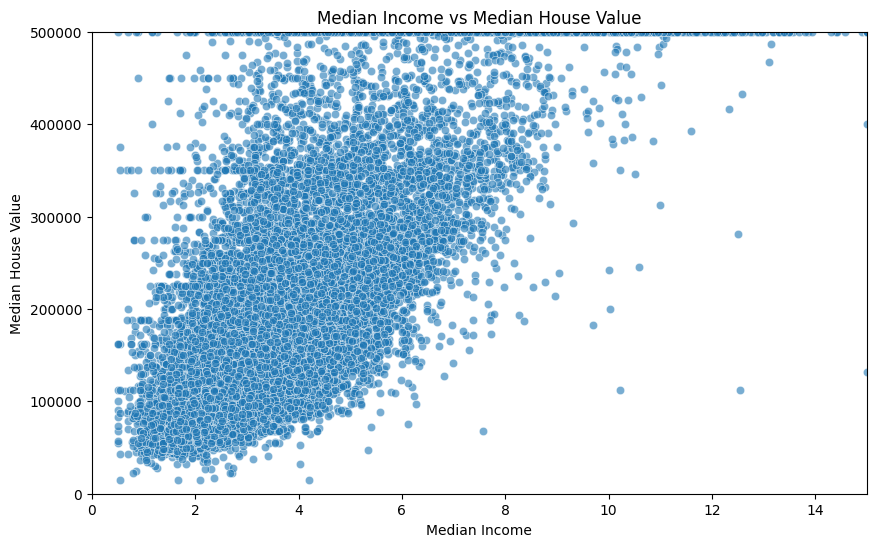

0.6918706037806693수입과 집값 사이에는 약 0.69의 상관관계가 있습니다. 이는 두 변수 간에 강한 양의 상관관계가 있음을 나타냅니다. 즉, 수입이 증가할수록 집값도 증가하는 경향이 있습니다.

위의 산점도를 통해 이 관계를 시각적으로 확인할 수 있습니다.수입과 집값 사이에는 약 0.69의 상관관계가 있습니다. 이는 두 변수 간에 강한 양의 상관관계가 있음을 나타냅니다. 즉, 수입이 증가할수록 집값도 증가하는 경향이 있습니다.

위의 산점도를 통해 이 관계를 시각적으로 확인할 수 있습니다.

> Finished chain.


{'input': '수입과 집값은 상관있어?',
 'output': '수입과 집값 사이에는 약 0.69의 상관관계가 있습니다. 이는 두 변수 간에 강한 양의 상관관계가 있음을 나타냅니다. 즉, 수입이 증가할수록 집값도 증가하는 경향이 있습니다.\n\n위의 산점도를 통해 이 관계를 시각적으로 확인할 수 있습니다.'}

In [6]:
agent.invoke({"input": "수입과 집값은 상관있어?"})



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "# Filter the DataFrame for houses with 1 and 2 bedrooms\nhouses_1_bedroom = df[df['total_bedrooms'] == 1]\nhouses_2_bedrooms = df[df['total_bedrooms'] == 2]\n\n# Calculate the mean and median house values\nmean_1_bedroom = houses_1_bedroom['median_house_value'].mean()\nmedian_1_bedroom = houses_1_bedroom['median_house_value'].median()\nmean_2_bedroom = houses_2_bedrooms['median_house_value'].mean()\nmedian_2_bedroom = houses_2_bedrooms['median_house_value'].median()\n\n# Create a DataFrame for visualization\nsummary_df = pd.DataFrame({\n    'Mean': [mean_1_bedroom, mean_2_bedroom],\n    'Median': [median_1_bedroom, median_2_bedroom]\n}, index=['1 Bedroom', '2 Bedrooms'])\n\nsummary_df"}`


                Mean    Median
1 Bedroom   500001.0  500001.0
2 Bedrooms  137500.0  137500.0

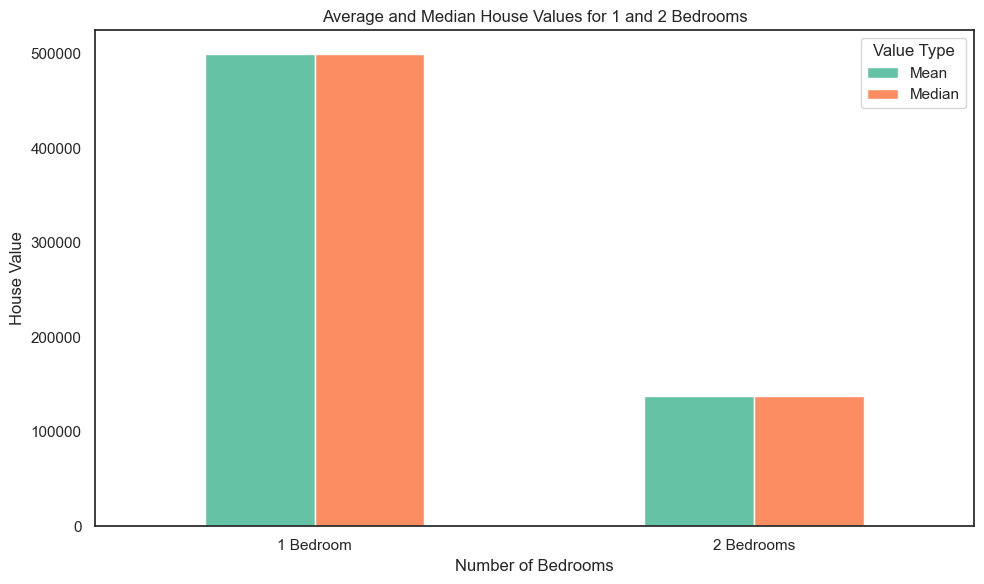


Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Set the style for seaborn\nsns.set(style='white')\n\n# Create a barplot for the mean and median values\nsummary_df.plot(kind='bar', figsize=(10, 6), color=['#66c2a5', '#fc8d62'])\nplt.title('Average and Median House Values for 1 and 2 Bedrooms')\nplt.ylabel('House Value')\nplt.xlabel('Number of Bedrooms')\nplt.xticks(rotation=0)\nplt.legend(title='Value Type')\nplt.tight_layout()\nplt.show()"}`


1개 침실과 2개 침실의 집값 평균 및 중간값을 계산한 결과는 다음과 같습니다:

- **1 Bedroom**: 
  - 평균 집값: 500,001
  - 중간값 집값: 500,001

- **2 Bedrooms**: 
  - 평균 집값: 137,500
  - 중간값 집값: 137,500

이 데이터를 바탕으로 시각화한 결과는 위의 바플롯에서 확인할 수 있습니다.1개 침실과 2개 침실의 집값 평균 및 중간값을 계산한 결과는 다음과 같습니다:

- **1 Bedroom**: 
  - 평균 집값: 500,001
  - 중간값 집값: 500,001

- **2 Bedrooms**: 
  - 평균 집값: 137,500
  - 중간값 집값: 137,500

이 데이터를 바탕으로 시각화한 결과는 위의 바플롯에서 확인할 수 있습니다.

> Finished chain.


{'input': '침실의 개수가 1개인 집과 2개인 집의 집값의 평균과 중간값을 구하고, 차이를 barplot으로 시각화하세요',
 'output': '1개 침실과 2개 침실의 집값 평균 및 중간값을 계산한 결과는 다음과 같습니다:\n\n- **1 Bedroom**: \n  - 평균 집값: 500,001\n  - 중간값 집값: 500,001\n\n- **2 Bedrooms**: \n  - 평균 집값: 137,500\n  - 중간값 집값: 137,500\n\n이 데이터를 바탕으로 시각화한 결과는 위의 바플롯에서 확인할 수 있습니다.'}

In [7]:
agent.invoke({"input": "침실의 개수가 1개인 집과 2개인 집의 집값의 평균과 중간값을 구하고, 차이를 barplot으로 시각화하세요"})